# Optimal Batting Order via Markov Chains

In [30]:
import random
import itertools
from collections import deque
from pybaseball import batting_stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

I use the library pybaseball to get statistics for the Red Sox 2025 season.

In [ ]:


df = batting_stats(2025, qual=0) # don't require a minimum number of plate appearances

# filter for Boston Red Sox players
bos_hitters = df[df['Team'] == 'BOS']
# sort by plate appearances
top_hitters = bos_hitters.sort_values(by='PA', ascending=False).head(15)


def get_probabilities(row):
    pa = row['PA'] # plate appearances
    singles = row['H'] - row['2B'] - row['3B'] - row['HR'] # total hits minus 
    return {
        'name': row['Name'],
        '1B' : singles / pa,
        '2B' : row['2B'] / pa,
        '3B' : row['3B'] / pa,
        'HR' : row['HR'] / pa, # home runs
        'BB' : row['BB'] / pa, # walks
        'out' : 1 - (
            (row['H'] + row['BB']) / pa )
            # 1 - (hits + walks) / plate appearances
            # includes strikeouts and out in play
    }

# Generate stats
player_stats = [get_probabilities(row) for _, row in top_hitters.iterrows()]
for stat in player_stats:
    print(stat)


{'name': 'Jarren Duran', '1B': 0.1590909090909091, '2B': 0.05113636363636364, '3B': 0.022727272727272728, 'HR': 0.011363636363636364, 'BB': 0.056818181818181816, 'out': 0.6988636363636364}
{'name': 'Rafael Devers', '1B': 0.10982658959537572, '2B': 0.06358381502890173, '3B': 0.0, 'HR': 0.028901734104046242, 'BB': 0.16184971098265896, 'out': 0.6358381502890174}
{'name': 'Alex Bregman', '1B': 0.1437125748502994, '2B': 0.08982035928143713, '3B': 0.0, 'HR': 0.05389221556886228, 'BB': 0.08982035928143713, 'out': 0.6227544910179641}
{'name': 'Trevor Story', '1B': 0.19205298013245034, '2B': 0.013245033112582781, '3B': 0.0, 'HR': 0.033112582781456956, 'BB': 0.039735099337748346, 'out': 0.7218543046357616}
{'name': 'Wilyer Abreu', '1B': 0.1357142857142857, '2B': 0.05, '3B': 0.0, 'HR': 0.06428571428571428, 'BB': 0.15, 'out': 0.6}
{'name': 'Kristian Campbell', '1B': 0.15555555555555556, '2B': 0.05925925925925926, '3B': 0.0, 'HR': 0.02962962962962963, 'BB': 0.14074074074074075, 'out': 0.61481481481

The Sox's most frequently used lineup is pasted, in order, below:

This project will explore whether this is truly the optimal batting order of these players.

In [7]:
true_lineup = [{'name': 'Jarren Duran', '1B': 0.1569767441860465, '2B': 0.05232558139534884, '3B': 0.023255813953488372, 'HR': 0.011627906976744186, 'BB': 0.05813953488372093, 'out': 0.6976744186046512},
{'name': 'Rafael Devers', '1B': 0.11242603550295859, '2B': 0.0650887573964497, '3B': 0.0, 'HR': 0.029585798816568046, 'BB': 0.15976331360946747, 'out': 0.6331360946745562},
{'name': 'Alex Bregman', '1B': 0.1411042944785276, '2B': 0.08588957055214724, '3B': 0.0, 'HR': 0.049079754601226995, 'BB': 0.09202453987730061, 'out': 0.6319018404907976},
{'name': 'Wilyer Abreu', '1B': 0.13970588235294118, '2B': 0.04411764705882353, '3B': 0.0, 'HR': 0.051470588235294115, 'BB': 0.15441176470588236, 'out': 0.6102941176470589},
{'name': 'Trevor Story', '1B': 0.19727891156462585, '2B': 0.013605442176870748, '3B': 0.0, 'HR': 0.034013605442176874, 'BB': 0.04081632653061224, 'out': 0.7142857142857143},
{'name': 'Triston Casas', '1B': 0.10714285714285714, '2B': 0.026785714285714284, '3B': 0.0, 'HR': 0.026785714285714284, 'BB': 0.09821428571428571, 'out': 0.7410714285714286},
{'name': 'Kristian Campbell', '1B': 0.15267175572519084, '2B': 0.061068702290076333, '3B': 0.0, 'HR': 0.030534351145038167, 'BB': 0.1450381679389313, 'out': 0.6106870229007634},
{'name': 'Connor Wong', '1B': 0.11764705882352941, '2B': 0.0, '3B': 0.0, 'HR': 0.0, 'BB': 0.08823529411764706, 'out': 0.7941176470588236},
{'name': 'Ceddanne Rafaela', '1B': 0.14285714285714285, '2B': 0.025210084033613446, '3B': 0.008403361344537815, 'HR': 0.01680672268907563, 'BB': 0.058823529411764705, 'out': 0.7478991596638656}]

df = pd.DataFrame(true_lineup)
df.head(9)

,name,1B,2B,3B,HR,BB,out
0,Jarren Duran,0.156977,0.052326,0.023256,0.011628,0.058140,0.697674
1,Rafael Devers,0.112426,0.065089,0.000000,0.029586,0.159763,0.633136
2,Alex Bregman,0.141104,0.085890,0.000000,0.049080,0.092025,0.631902
3,Wilyer Abreu,0.139706,0.044118,0.000000,0.051471,0.154412,0.610294
4,Trevor Story,0.197279,0.013605,0.000000,0.034014,0.040816,0.714286
5,Triston Casas,0.107143,0.026786,0.000000,0.026786,0.098214,0.741071
6,Kristian Campbell,0.152672,0.061069,0.000000,0.030534,0.145038,0.610687
7,Connor Wong,0.117647,0.000000,0.000000,0.000000,0.088235,0.794118
8,Ceddanne Rafaela,0.142857,0.025210,0.008403,0.016807,0.058824,0.747899


# Baseball Simulator

This simulator runs a game of baseball as a markov chain, assuming the following transition probabiltiies.

The transition probabilities are approximated from Baseball Reference Red Sox 2025 base running statistics:

https://www.baseball-reference.com/leagues/majors/2025-baserunning-batting.shtml

Walk (probability BB):

- Runners advance if forced

Single (probability 1B): 

- Batter advances to 1st

- Runner on 1st (if present) reaches third ~30% of the time and scores ~3% of the time 

- Runner on 2nd (if present) scores ~60% of the time 

Double (probability 2B):

- Batter advances to 2nd

- Runner on 1st (if present) scores 33% of the time

- Runner on 2nd (if present) scores 

- Runner on 3rd (if present) scores

Triple (probability 3B): 

- Batter advances to 3rd

- Any basemen score if present

Home Run (probability HR):

- Basemen and batter score

In [ ]:
class BaseballSimulator:
    def __init__(self, batting_order):
        self.lineup = deque(batting_order)  # rotating lineup

    def analyze_run_distribution(self, n=1000):
        runs_per_game = [self.simulate_game() for _ in range(n)]
        mean_runs = np.mean(runs_per_game)
        std_runs = np.std(runs_per_game)

        plt.figure(figsize=(10, 6))
        plt.hist(runs_per_game, bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Run Distribution Over {n} Simulated Games')
        plt.xlabel('Runs Scored')
        plt.ylabel('Frequency')
        plt.axvline(mean_runs, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_runs:.2f}')
        plt.legend()
        
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"Mean Runs per Game: {mean_runs:.2f}")
        print(f"Standard Deviation: {std_runs:.2f}")

    def simulate_n_games(self, n=1000):
        total_runs = 0
        for _ in range(n):
            total_runs += self.simulate_game()
        return total_runs / n

    def simulate_game(self):
        lineup = deque(self.lineup)  
        total_runs = 0
        for _ in range(9):  # 9 innings
            runs, lineup = self.simulate_inning(lineup)
            total_runs += runs
        return total_runs

    def simulate_inning(self, lineup):
        bases = [False, False, False]  # 1B, 2B, 3B
        outs = 0
        runs = 0

        while outs < 3:
            batter = lineup[0]
            outcome = self.get_outcome(batter)

            if outcome == 'out':
                outs += 1
            elif outcome == 'BB':
                runs += self.walk(bases)
            elif outcome == '1B':
                runs += self.single(bases)
            elif outcome == '2B':
                runs += self.double(bases)
            elif outcome == '3B':
                runs += self.triple(bases)
            elif outcome == 'HR':
                runs += self.homer(bases)
            lineup.rotate(-1)

        return runs, lineup

    def get_outcome(self, batter):
        outcomes = ['1B', '2B', '3B', 'HR', 'BB', 'out']
        probs = [batter.get(k, 0) for k in outcomes]
        return random.choices(outcomes, weights=probs, k=1)[0]

    def walk(self, bases):
        runs = 0
        # Check if all bases are occupied
        if bases[0] and bases[1] and bases[2]:
            runs += 1  # Runner on 3rd is forced home
        # Shift runners if they are forced
        if bases[1] and bases[0]:
            bases[2] = True  # Runner on 2nd is forced to 3rd
        elif not bases[2]:
            bases[2] = False

        if bases[0]:
            bases[1] = True  # Runner on 1st is forced to 2nd

        bases[0] = True  # Batter goes to 1st
        return runs

    def single(self, bases):
        runs = 0
        if bases[2]:
            runs += 1
            bases[2] = False
        if bases[1]:
            if random.random() < 0.6: # second baseman scores on single
                runs += 1
            else:
                bases[2] = True
            bases[1] = False
        if bases[0]:
            rand = random.random()
            if rand < 0.03: # first baseman scores on single
                runs += 1
            elif rand < 0.33: # first baseman gets to third on a single
                bases[2] = True
            else:
                bases[1] = True
            bases[0] = False
        bases[0] = True
        return runs

    def double(self, bases):
        runs = 0
        if bases[2]:
            runs += 1
            bases[2] = False
        if bases[1]:
            runs += 1
            bases[1] = False
        if bases[0]:
            if random.random() < 0.33: # first baseman scores on double
                runs += 1
            else:
                bases[2] = True
            bases[0] = False
        bases[1] = True
        return runs

    def triple(self, bases):
        runs = sum(1 for b in bases if b)
        bases[0], bases[1], bases[2] = False, False, True
        return runs

    def homer(self, bases):
        runs = 1 + sum(1 for b in bases if b)
        bases[0], bases[1], bases[2] = False, False, False
        return runs

As of May 7, 2025, the Boston Red Sox are averaging 4.86 runs per game during the MLB regular season. This figure is slightly above the franchise’s historical average of 4.67 runs per game. In this code block we see how the Sox's regular 2025 lineup score in simulation to see if our simulation is accurate. 


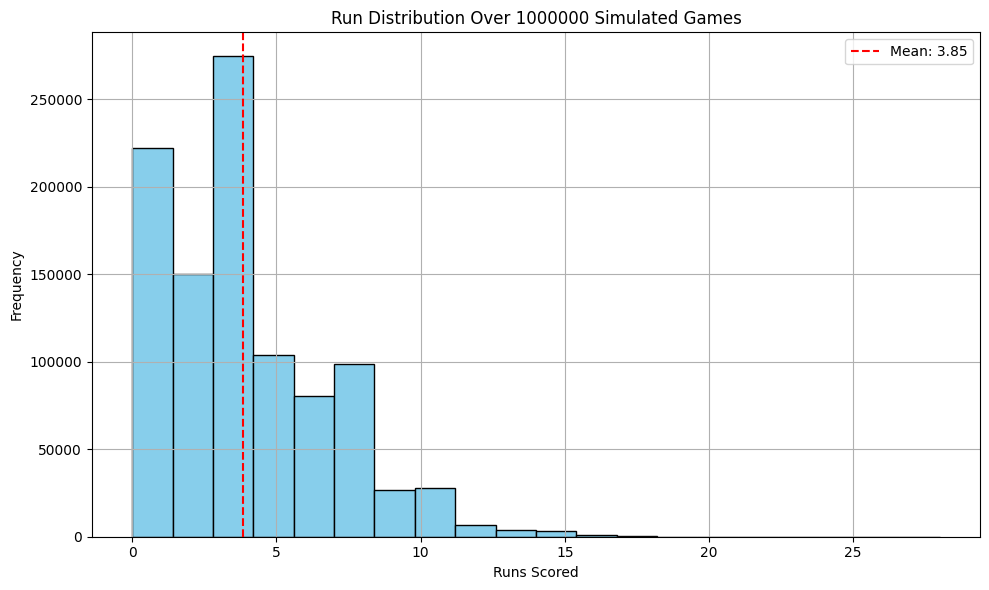

Mean Runs per Game: 3.85
Standard Deviation: 2.86


In [44]:
b = BaseballSimulator(true_lineup)
b.analyze_run_distribution(1000000)


We see a slightly lower average runs per game in our simulator, around 3.85, perhaps due to:

- We did not use exact base running statistics.
- There are other offensive plays we did not account for in this simulation (i.e. stealing). 
- The distribution of total runs per game may look different from our simulation since the batting statistics can vary heavily from game to game. I.e. in the simulation the Red Sox are up against an average team and average pitcher all the time, but if in reality the Red Sox sometimes plays really bad teams, and they might be able to score like 10 runs in those games and skew the distribution. A more advanced simulation could try account for this but it's beyond the scope of this project.

In any case, it's close enough that we can get an approximate idea of how well the Sox will score with different lineups.

Now let's analyze what value of n should be high enough to give us a good sense of the true sample mean, using the central limit theorem. 0.4 runs (0.2 on each side) seems like an acceptable width for the 95% confidence interval, given that each lineup is going to be scoring about 4 runs.

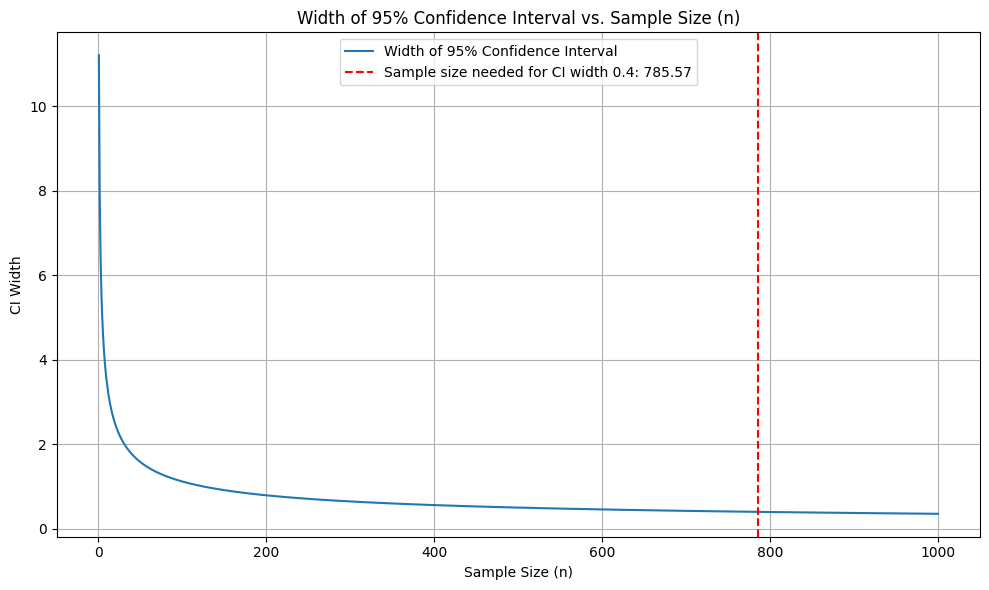

In [ ]:

n_values = np.arange(1, 1001)  
ci_95 = 2 * 1.96 * 2.86 / np.sqrt(n_values)
desired_width = 0.4
sample_size_needed = (2 * 1.96 * 2.86 / desired_width)**2
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_values, ci_95, label='Width of 95% Confidence Interval')
plt.title('Width of 95% Confidence Interval vs. Sample Size (n)')
plt.xlabel('Sample Size (n)')
plt.axvline(x=sample_size_needed, color='red', linestyle='--', label=f'Sample size needed for CI width {desired_width}: {sample_size_needed:.2f}')
plt.ylabel('CI Width')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Genetic Algorithm

There's a lot of literature on genetic algorithms, I learned about it in CS124. They can help us explore a state space and get a good local solution to an optimization problem without brute forcing all possible inputs.

In the genetic algorithm, we essentially treat the lineups like DNA. We begin with an initial population, which is a set of population_size random lineups of the nine players in the batting order. We calculate the fitness of each member of the population, which is just their average runs calculated through simulate_n_games. Then we stochastically select parents to reproduce via the crossover function. 
 
The genetic algorithm is explained in-depth in the accompanying Latex document.

In [ ]:

class GeneticAlgorithm:
    def __init__(self, population_size, generations, mutation_rate, batting_order, n_games=100):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.batting_order = batting_order
        self.n_games = n_games
        self.simulator = BaseballSimulator(batting_order)

    def initialize_population(self):
        # Generate random initial population of lineups
        population = []
        for _ in range(self.population_size):
            lineup = random.sample(self.simulator.lineup, len(self.simulator.lineup))  # Random permutation
            population.append(lineup)
        return population

    def fitness(self, lineup):
        # Calculate the fitness of a lineup as the average runs scored in n games
        self.simulator.lineup = deque(lineup)  # Set lineup
        return self.simulator.simulate_n_games(self.n_games)

    def select_parents(self, population):
        
        # fitness_scores = [self.fitness(lineup) for lineup in population]
        # total_fitness = sum(fitness_scores)
        # selection_probs = [score / total_fitness for score in fitness_scores]
        
        # parents = random.choices(population, weights=selection_probs, k=2)
        parent1 = max(random.sample(population, k=10), key=self.fitness)
        parent2 = max(random.sample(population, k=10), key=self.fitness)
        return parent1, parent2
        return parents

    def crossover(self, parent1, parent2):
        # Perform order crossover to ensure unique players in the child lineup
        size = len(parent1)
        start, end = sorted(random.sample(range(size), 2))

        child = [None] * size
        child[start:end] = parent1[start:end]

        fill_from = [player for player in parent2 if player not in child[start:end]]
        fill_index = 0

        for i in range(size):
            if child[i] is None:
                child[i] = fill_from[fill_index]
                fill_index += 1

        return child

    def mutate(self, lineup):
        # randomly swap two players
        if random.random() < self.mutation_rate:
            i, j = random.sample(range(len(lineup)), 2)
            lineup[i], lineup[j] = lineup[j], lineup[i]
        return lineup

    def evolve(self):
        history = []
        population = self.initialize_population()
        best_lineup = None
        best_fitness = -float('inf')

        for generation in range(self.generations):
            # Evaluate current population
            scored_population = [(lineup, self.fitness(lineup)) for lineup in population]
            scored_population.sort(key=lambda x: x[1], reverse=True)

            # Track best lineup
            top_lineup, top_fitness = scored_population[0]
            if top_fitness > best_fitness:
                best_fitness = top_fitness
                best_lineup = top_lineup

            # Log fitness
            avg_fitness = sum(score for _, score in scored_population) / len(scored_population)
            history.append({
                "best": top_fitness,
                "average": avg_fitness
            })

            print(f"Generation {generation + 1}: Best = {top_fitness:.3f}, Avg = {avg_fitness:.3f}")

            # Elitism, carry over top 2 directly
            new_population = [lineup for lineup, _ in scored_population[:2]]

            # new_population = []
            # Fill rest of population
            while len(new_population) < self.population_size:
                parent1, parent2 = self.select_parents(population)
                child1 = self.mutate(self.crossover(parent1, parent2))
                child2 = self.mutate(self.crossover(parent2, parent1))
                new_population.extend([child1, child2])

            population = new_population[:self.population_size]

        return best_lineup, best_fitness, history
    
    def plot_history(self, history):
        generations = list(range(len(history)))
        avg_fitness = [gen['average'] for gen in history]
        best_fitness = [gen['best'] for gen in history]

        plt.figure(figsize=(10, 6))
        plt.plot(generations, avg_fitness, label='Average Fitness', marker='o')
        plt.plot(generations, best_fitness, label='Best Fitness', marker='s')
        plt.title("Genetic Algorithm: Fitness Evolution")
        plt.xlabel("Generation")
        plt.ylabel("Runs per Game")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



# Playing with the model

In [11]:
silly_lineup = [{'name': 'Stephen Singlehitter', '1B': 1, '2B': 0, '3B': 0, 'HR': 0, 'BB': 0, 'out': 0},
{'name': 'Daniel Doublehitter', '1B': 0, '2B': 1/2, '3B': 0, 'HR': 0, 'BB': 0, 'out': 1/2},
{'name': 'Terrence Tripplehitter', '1B': 0, '2B': 0, '3B': 1/3, 'HR': 0, 'BB': 0, 'out': 2/3},
{'name': 'Harry Homerunner', '1B': 0, '2B': 0, '3B': 0, 'HR': 1/4, 'BB': 0, 'out': 3/4},
{'name': 'William Walker', '1B': 0, '2B': 0, '3B': 0, 'HR': 0, 'BB': 1, 'out': 1},
{'name': 'Larry Loser', '1B': 0, '2B': 0, '3B': 0, 'HR': 0, 'BB': 0, 'out': 1}]
pd.DataFrame(silly_lineup).head(6)

,name,1B,2B,3B,HR,BB,out
0,Stephen Singlehitter,1,0.0,0.000000,0.00,0,0.000000
1,Daniel Doublehitter,0,0.5,0.000000,0.00,0,0.500000
2,Terrence Tripplehitter,0,0.0,0.333333,0.00,0,0.666667
3,Harry Homerunner,0,0.0,0.000000,0.25,0,0.750000
4,William Walker,0,0.0,0.000000,0.00,1,1.000000
5,Larry Loser,0,0.0,0.000000,0.00,0,1.000000


Generation 1: Best = 11.790, Avg = 9.870
Generation 2: Best = 12.088, Avg = 11.134
Generation 3: Best = 12.251, Avg = 11.116
Generation 4: Best = 12.389, Avg = 11.484
Generation 5: Best = 12.575, Avg = 11.614
Generation 6: Best = 12.479, Avg = 12.221
Generation 7: Best = 12.487, Avg = 11.978
Generation 8: Best = 12.431, Avg = 12.001
Generation 9: Best = 12.688, Avg = 12.273
Generation 10: Best = 12.688, Avg = 12.106
Generation 11: Best = 12.606, Avg = 12.111
Generation 12: Best = 12.549, Avg = 12.222
Generation 13: Best = 12.539, Avg = 11.761
Generation 14: Best = 12.446, Avg = 12.125
Generation 15: Best = 12.627, Avg = 12.265
Generation 16: Best = 12.675, Avg = 11.828
Generation 17: Best = 12.437, Avg = 12.004
Generation 18: Best = 12.526, Avg = 12.281
Generation 19: Best = 12.524, Avg = 12.075
Generation 20: Best = 12.589, Avg = 11.920


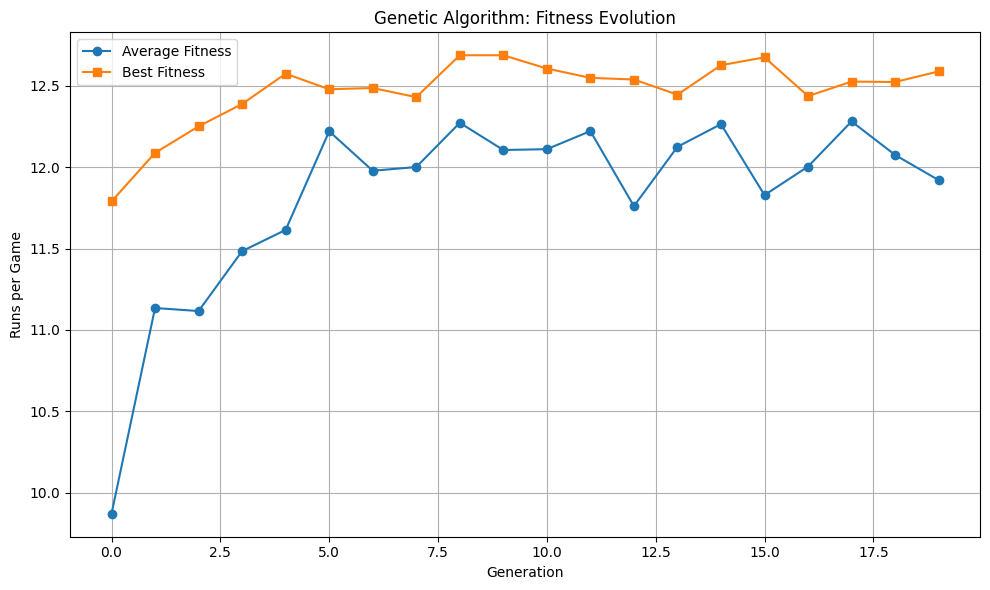


Best Batting Order After Evolution:
William Walker
Daniel Doublehitter
Stephen Singlehitter
Terrence Tripplehitter
Harry Homerunner
Larry Loser
Best Fitness (Average Runs): 12.69


In [ ]:
silly_ga = GeneticAlgorithm(
    population_size=20,  # Set the size of the population
    generations=20,  # Number of generations to evolve
    mutation_rate=0.1,  # Probability of mutation
    batting_order=silly_lineup,  # Initial batting order 
    n_games=785  # Number of games to simulate for each lineup
)
silly_lineup, silly_fitness, silly_history = silly_ga.evolve()
silly_ga.plot_history(silly_history)
print("\nBest Batting Order After Evolution:")
for player in silly_lineup:
    print(player['name'])
print(f"Best Fitness (Average Runs): {silly_fitness:.2f}")

This silly lineup is basically a sanity check that the genetic algorithm is working.

Common sense dictates that the harder-hitting players should go later, so we can load up the bases first with OBP batters and then get them all to run. Intuition says the order should be something like: William, Stephen, Daniel, Terrence, Harry, Larry. The simulation agrees with this conclusion, except it consistently suggests that Daniel should go before Stephen, which actually makes sense since based on the Baseball Reference base running statistics we used, the chances for a player on 2nd to score on a single are quite much higher than the chances for a player on 1st to score on a double. 

# Running it on the Sox lineup

In [118]:
ga = GeneticAlgorithm(
    population_size=30,  
    generations=100,  # Number of generations to evolve
    mutation_rate=0.1,  # Probability of mutation
    batting_order=true_lineup,  # Initial batting order
    n_games=785  # Number of games to simulate for each lineup
)

# Evolve the population and find the best lineup
best_lineup, best_fitness, history = ga.evolve()

print("\nBest Batting Order After Evolution:")
for player in best_lineup:
    print(player['name'])


Generation 1: Best = 4.038, Avg = 3.813
Generation 2: Best = 4.056, Avg = 3.829
Generation 3: Best = 4.134, Avg = 3.889
Generation 4: Best = 4.135, Avg = 3.904
Generation 5: Best = 4.135, Avg = 3.930
Generation 6: Best = 4.162, Avg = 3.890
Generation 7: Best = 4.150, Avg = 3.973
Generation 8: Best = 4.190, Avg = 3.920
Generation 9: Best = 4.146, Avg = 3.971
Generation 10: Best = 4.181, Avg = 3.943
Generation 11: Best = 4.183, Avg = 3.979
Generation 12: Best = 4.110, Avg = 3.931
Generation 13: Best = 4.219, Avg = 3.965
Generation 14: Best = 4.282, Avg = 3.931
Generation 15: Best = 4.268, Avg = 3.936
Generation 16: Best = 4.194, Avg = 3.923
Generation 17: Best = 4.158, Avg = 3.923
Generation 18: Best = 4.051, Avg = 3.936
Generation 19: Best = 4.171, Avg = 3.952
Generation 20: Best = 4.164, Avg = 3.950
Generation 21: Best = 4.190, Avg = 3.922
Generation 22: Best = 4.082, Avg = 3.930
Generation 23: Best = 4.167, Avg = 3.929
Generation 24: Best = 4.117, Avg = 3.965
Generation 25: Best = 4.1

In [119]:

pd.DataFrame(best_lineup).head(9) 



,name,1B,2B,3B,HR,BB,out
0,Rafael Devers,0.112426,0.065089,0.000000,0.029586,0.159763,0.633136
1,Kristian Campbell,0.152672,0.061069,0.000000,0.030534,0.145038,0.610687
2,Wilyer Abreu,0.139706,0.044118,0.000000,0.051471,0.154412,0.610294
3,Alex Bregman,0.141104,0.085890,0.000000,0.049080,0.092025,0.631902
4,Jarren Duran,0.156977,0.052326,0.023256,0.011628,0.058140,0.697674
5,Trevor Story,0.197279,0.013605,0.000000,0.034014,0.040816,0.714286
6,Ceddanne Rafaela,0.142857,0.025210,0.008403,0.016807,0.058824,0.747899
7,Triston Casas,0.107143,0.026786,0.000000,0.026786,0.098214,0.741071
8,Connor Wong,0.117647,0.000000,0.000000,0.000000,0.088235,0.794118


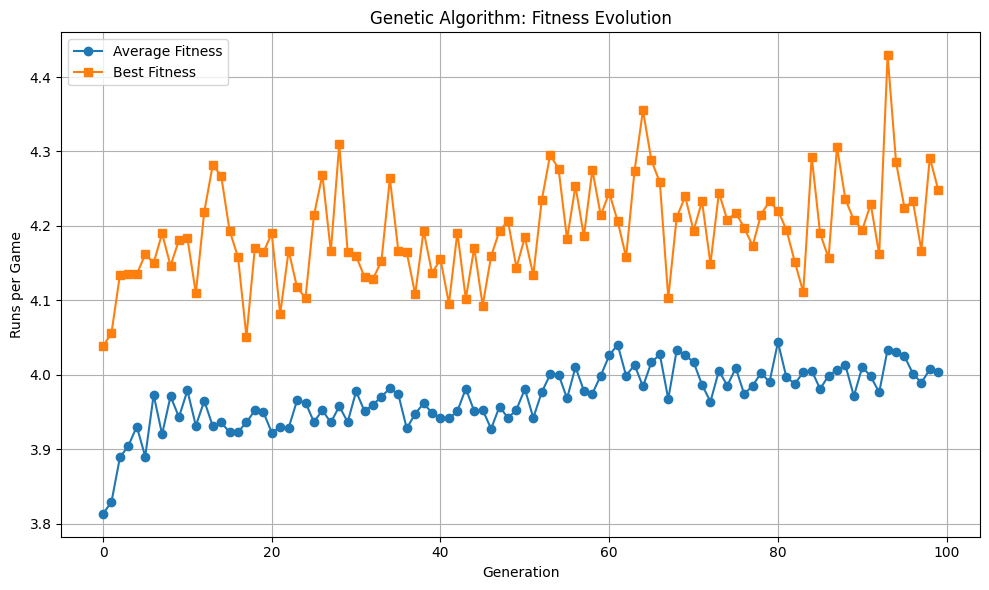

Best Fitness (Average Runs): 4.43


In [120]:

ga.plot_history(history)
print(f"Best Fitness (Average Runs): {best_fitness:.2f}")


The training history shows that the genetic algorithm is working as intended, showing steady improvement which begins to plateau around 20 generations. With the new lineup, we manage to improve the team's average runs per game by almost one entire run.

# Sensitivity analysis: adding gaussian noise

In [121]:
def add_gaussian_noise(lineup, std_dev=0.05):
    df = pd.DataFrame(lineup)
    
    # We will add noise to the following 5 columns
    stat_cols = ['1B', '2B', '3B', 'HR', 'BB']
    
    for col in stat_cols:
        noise = np.random.normal(0, std_dev, size=len(df))
        df[col] = (df[col] + noise).clip(lower=0)  # can't have negative probabilities

    # Recalculate 'out' as 1 - sum of the first 5 stats -- to normalize
    df['out'] = 1 - df[stat_cols].sum(axis=1)
    
    return df.to_dict(orient='records')
noisy_lineup = add_gaussian_noise(true_lineup)
pd.DataFrame(noisy_lineup)

,name,1B,2B,3B,HR,BB,out
0,Jarren Duran,0.133379,0.000000,0.124532,0.000000,0.020803,0.721286
1,Rafael Devers,0.038963,0.055469,0.000000,0.000000,0.161149,0.744419
2,Alex Bregman,0.172300,0.130790,0.000000,0.061222,0.100800,0.534888
3,Wilyer Abreu,0.033150,0.039489,0.000000,0.022606,0.118943,0.785812
4,Trevor Story,0.148469,0.020038,0.021847,0.052719,0.047580,0.709347
5,Triston Casas,0.047901,0.110020,0.029183,0.035038,0.000000,0.777858
6,Kristian Campbell,0.160950,0.096706,0.037884,0.000000,0.184792,0.519669
7,Connor Wong,0.074864,0.000000,0.016115,0.082296,0.081935,0.744791
8,Ceddanne Rafaela,0.120108,0.003750,0.042535,0.041142,0.006435,0.786030


In [122]:
ga_noisy = GeneticAlgorithm(
    population_size=30,  # Set the size of the population
    generations=100,  # Number of generations to evolve
    mutation_rate=0.1,  # Probability of mutation (swap two players)
    batting_order=noisy_lineup,  # Initial batting order (input players' data)
    n_games=785  # Number of games to simulate for each lineup
)

# Evolve the population and find the best lineup
best_lineup, best_fitness, history = ga_noisy.evolve()

print("\nBest Batting Order After Evolution:")
for player in best_lineup:
    print(player['name'])

Generation 1: Best = 4.395, Avg = 4.176
Generation 2: Best = 4.434, Avg = 4.211
Generation 3: Best = 4.540, Avg = 4.325
Generation 4: Best = 4.623, Avg = 4.353
Generation 5: Best = 4.655, Avg = 4.412
Generation 6: Best = 4.611, Avg = 4.402
Generation 7: Best = 4.720, Avg = 4.509
Generation 8: Best = 4.605, Avg = 4.432
Generation 9: Best = 4.605, Avg = 4.458
Generation 10: Best = 4.646, Avg = 4.528
Generation 11: Best = 4.764, Avg = 4.495
Generation 12: Best = 4.752, Avg = 4.507
Generation 13: Best = 4.715, Avg = 4.521
Generation 14: Best = 4.754, Avg = 4.537
Generation 15: Best = 4.762, Avg = 4.483
Generation 16: Best = 4.792, Avg = 4.519
Generation 17: Best = 4.743, Avg = 4.512
Generation 18: Best = 4.755, Avg = 4.546
Generation 19: Best = 4.713, Avg = 4.537
Generation 20: Best = 4.736, Avg = 4.487
Generation 21: Best = 4.803, Avg = 4.494
Generation 22: Best = 4.680, Avg = 4.503
Generation 23: Best = 4.799, Avg = 4.557
Generation 24: Best = 4.831, Avg = 4.523
Generation 25: Best = 4.8